# AI Offline Parcel example

This notebook demonstrates how to use the `nearmap_ai` package to pull data from the AI features API on a per parcel basis, filter out features we do not not consider part of the parcels, and to transform (rollup) the data into a tabular format.

In [1]:
import os
import shutil
from pathlib import Path
import logging
import random

from descartes import PolygonPatch
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# Local utilities
from nearmap_ai.feature_api import FeatureApi
from nearmap_ai import constants, log, parcels

# Logging level - set this to determine what level of info is returned. "DEBUG" adds timings for API responses.
log.configure_logger(logging.INFO)

# Display a bit more than the default pandas row and columns
pd.set_option("max_columns", 100)
pd.set_option("max_rows", 500)

# Path to local API response cache
CACHE_DIR = Path("./cache")

# Number of exampels to show
N_EXAMPLES = 10
random.seed(10)

### Which AI Packs and Feature Classes to use?

The following cell controls which class IDs are used (anything not in `ALL_USED_IDS` is ignored). It starts to look very cluttered with all packs, so a subset of these (`VISUALISATION_IDS`) is used for the visualisation of examples.

The source of truth for feature class IDs is the "classes.json" endpoint of the API, which can be refreshed periodically to add new feature class IDs to existing packs, update any changed descriptions, or reflect any new AI Packs added to your subscription.

### Date Restrictions
`SINCE` and `UNTIL` allow a generic restriction of dates. The latest published AI results within that time window will be returned.

In [2]:
# Store your Nearmap API Key in an environment variable so it doesn't appear in the notebook.
API_KEY = os.environ["API_KEY"]

# Get pack codes from https://api.nearmap.com/ai/features/v4/packs.json
PACKS = [
    "building",
    "building_char",
    "roof_char",
    "solar",
    "construction",
    "trampoline",
    "pool",
    "vegetation",
    "surfaces",
]

ALL_USED_IDS = (
    [
        constants.BUILDING_ID, 
        constants.ROOF_ID, 
        constants.TRAMPOLINE_ID, 
        constants.POOL_ID, 
        constants.CONSTRUCTION_ID, 
        constants.SOLAR_ID
    ]
    + constants.VEG_IDS
    + constants.SURFACES_IDS
    + constants.ROOF_CHAR_IDS
)
VISUALISATION_IDS = [
    constants.BUILDING_ID,
    constants.ROOF_ID,
    constants.TRAMPOLINE_ID,
    constants.POOL_ID,
    constants.CONSTRUCTION_ID,
    constants.SOLAR_ID,
] + constants.VEG_IDS

# Data date range
SINCE, UNTIL = ("2016-01-01", "2022-12-31")

## FeatureApi

The `FeatureApi` class is used for interacting with the AI Feature API. The class takes care of caching (if configured), retrying and error handling, and concurrency.

In [3]:
# Create instance
feature_api = FeatureApi(api_key=API_KEY, cache_dir=CACHE_DIR)

In [4]:
# Get classes (this pulls data from https://api.nearmap.com/ai/features/v4/classes.json)
df_classes = feature_api.get_feature_classes().loc[ALL_USED_IDS, :]
df_classes.head(5)

,type,description,schema
id,,,
a2e4ae39-8a61-5515-9d18-8900aa6e6072,Feature,Building,NaN
c08255a4-ba9f-562b-932c-ff76f2faeeeb,Feature,Roof,NaN
753621ee-0b9f-515e-9bcf-ea40b96612ab,Feature,Trampoline,NaN
0339726f-081e-5a6e-b9a9-42d95c1b5c8a,Feature,Swimming Pool,NaN
a2a81381-13c6-57dc-a967-af696e45f6c7,Feature,Construction Site,NaN


### SHOULD I CLEAR THE CACHE?
WARNING: this clears the cache. PLEASE CONFIRM YOU HAVE STORED ANY PAYLOADS SAFELY PRIOR TO DOING THIS!!! Otherwise, you may lose data you have downloaded.

Cache is keyed by a hash of the request string (without the API key). If fresh AI results are published that correspond to the same parameter set, repeating the same pull (after deleting the cache) may have different results.


In [5]:
CLEAR_CACHE = False

if CLEAR_CACHE:
    shutil.rmtree(CACHE_DIR, ignore_errors=True)
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Load Query AOI (parcel) data
A query AOI is the polygon within which a section of our AI vector maps will be returned. This is most commonly used as property parcel boundaries.

We need our query AOI data to have two key fields (but others are also ok):
 - `aoi_id`: A unique identifier
 - `geometry`: A polygon or multipolygon geometry (in this case in EPSG 4326)
 
See nearmap_ai.parcels.read_from_file for supported formats.

There are some automated cleanup internal to the function to:
- Check for duplicate ids (which may indicate a data input issue)
- Drop any rows where the geometry field is empty.

Results are then plotted for an overview.

Number of parcels 100


,aoi_id,geometry
0,370dcd28-692a-52cd-b44e-3a88cb2605a8,"POLYGON ((-74.27516 40.64219, -74.27542 40.642..."
1,92aa29b8-1105-57d3-9638-b9ab151778a9,"POLYGON ((-74.27687 40.63502, -74.27721 40.635..."
2,656263e0-2cfb-5184-9fb3-f4f7eadc6c3b,"POLYGON ((-74.28236 40.63437, -74.28263 40.634..."
3,1f5ea3af-ac86-5b9e-b206-94ac79683840,"POLYGON ((-74.28706 40.63083, -74.28708 40.631..."
4,a4054bde-22d2-5acd-995e-b403282d5505,"POLYGON ((-74.27405 40.63673, -74.27413 40.636..."


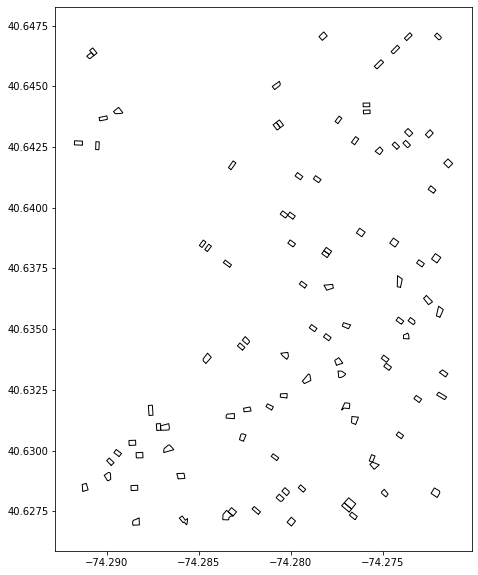

In [6]:
# Read parcel test data set using the nearmap_ai.parcels module
parcels_gdf = parcels.read_from_file(Path("../tests/data/test_parcels_2.csv"))
# Country, used for projections (make sure this matches the parcel data)
country = "US"

# Show - map will show blank if small parcels are very spread out
print(f"Number of parcels {len(parcels_gdf)}")
parcels_gdf.plot(figsize=(10, 10), fc="none", ec="k", lw=1)
display(parcels_gdf.head())

sample_indices = random.sample(range(len(parcels_gdf)), N_EXAMPLES)

# Fetching data from the API

By using a local cache the FeatureApi class do not have to make the same request multiple times. This cache forms a repository of all source data downloaded from the API, and should be stored as a record in case of subsequent processing bugs. This means that adjustments can be made to the post processing pipeline without needing to spend additional credits on the API.

The `get_features_gdf_bulk` method uses a thread pool to pull data concurrently.

In [7]:
features_gdf, metadata_df, error_df = feature_api.get_features_gdf_bulk(
    parcels_gdf, PACKS, since_bulk=SINCE, until_bulk=UNTIL
)

The examples show features for a few query AOIs. Note how features on the edge of query AOI boundaries are included. All packs except `vegetation` and `surfaces` include any whole objects that intersect with the query AOI. Those are considered "connected" classes which may include extremely large features such as forests or oceans - so they are clipped to the intersection of the feature and the query AOI boundary.

10it [00:04,  2.50it/s]


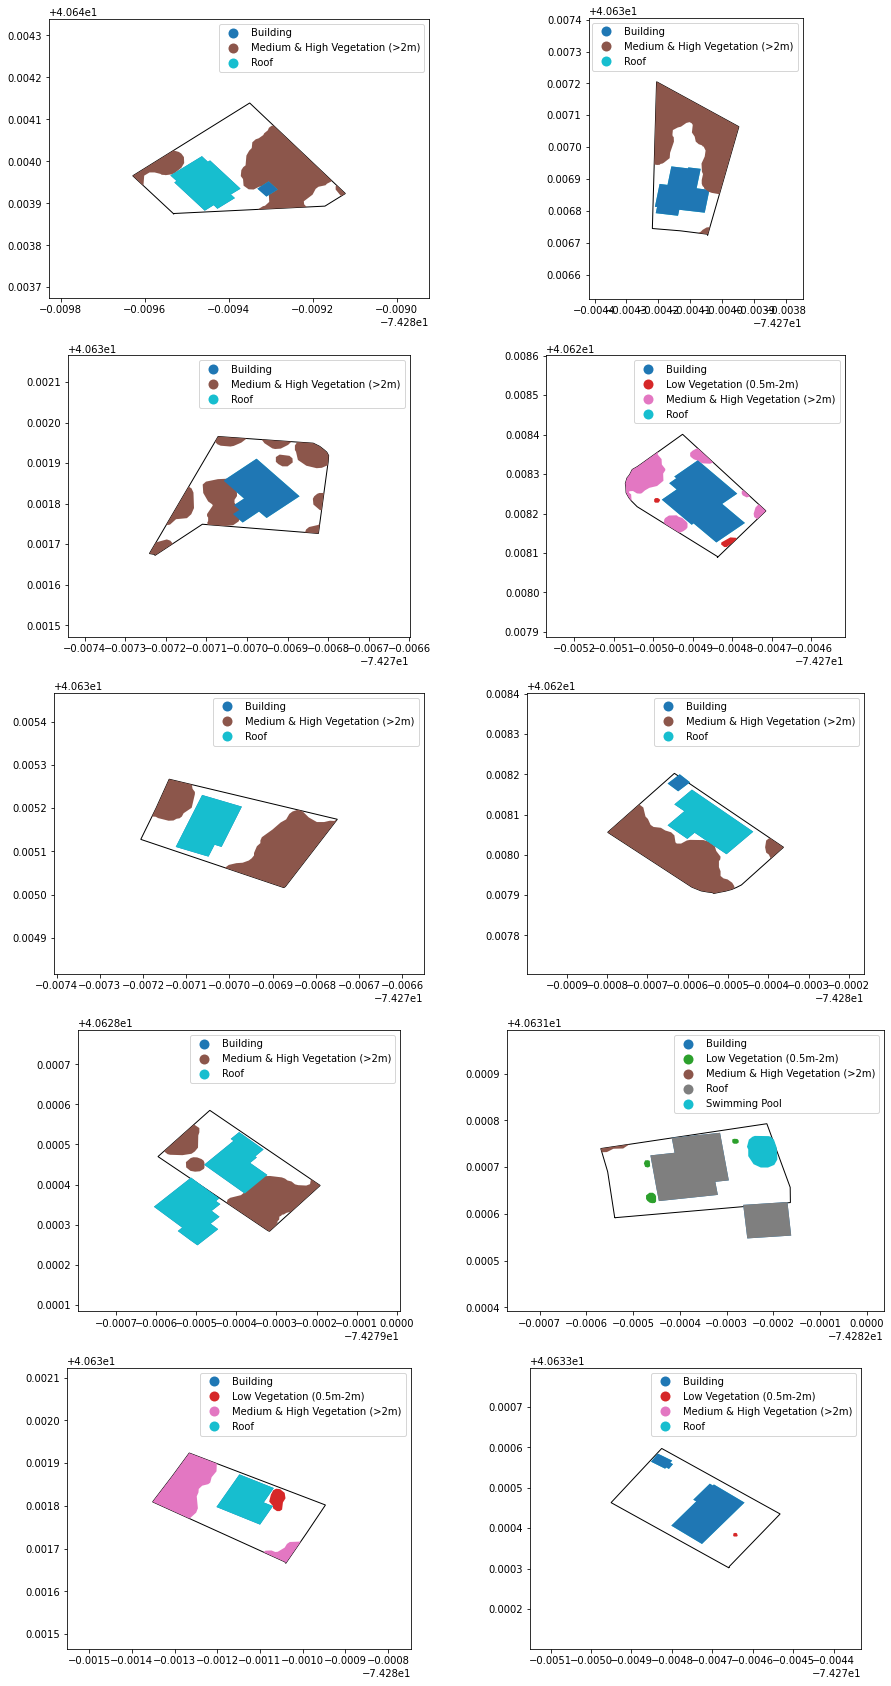

In [8]:
# Plot a few examples
fig, axes = plt.subplots(N_EXAMPLES // 2, 2, figsize=(15, 3 * N_EXAMPLES))
axes = [ax for row in axes for ax in row]
plot_buffer = 2e-4
for i, index in tqdm(enumerate(sample_indices)):
    row = parcels_gdf.loc[index]
    parcel_features_gdf = features_gdf[features_gdf.aoi_id == row.aoi_id]
    parcel_features_gdf.query("class_id in @VISUALISATION_IDS").plot(
        ax=axes[i], column="description", legend=True
    )
    axes[i].add_patch(
        PolygonPatch(row.geometry, fc="none", ec="k", alpha=1, zorder=0, lw=1)
    )
    axes[i].set_xlim(row.geometry.bounds[0] - plot_buffer, row.geometry.bounds[2] + plot_buffer)
    axes[i].set_ylim(row.geometry.bounds[1] - plot_buffer, row.geometry.bounds[3] + plot_buffer)
    axes[i].set_aspect("equal", "box")

# Filter features

As seen in the previous examples, there are often features on the edge of parcels that we want to reject, as a slight mismatch may exist between the AI results (in non epoch adjusted EPSG:4326) and the query AOI. This mismatch is most commonly caused by slight parcel boundary location errors. In this notebook we apply four filters:
 - Low area features
 - Low confidence features
 - Features that are mostly outside the parcel, unless there is significant area overlap
 - Feature classes without defined filtering parameters are automatically included if listed in the `ALL_USED_IDS` constant.
 
Defualt thresholds for these filters are defined in `nearmap_ai.parcels`. Any of the default values can be overwritten by passing in a config dictionary to the `filter_features_in_parcels` function.

Plot a few examples. Red and black striped features were discarded by the filter.

10it [00:05,  1.70it/s]


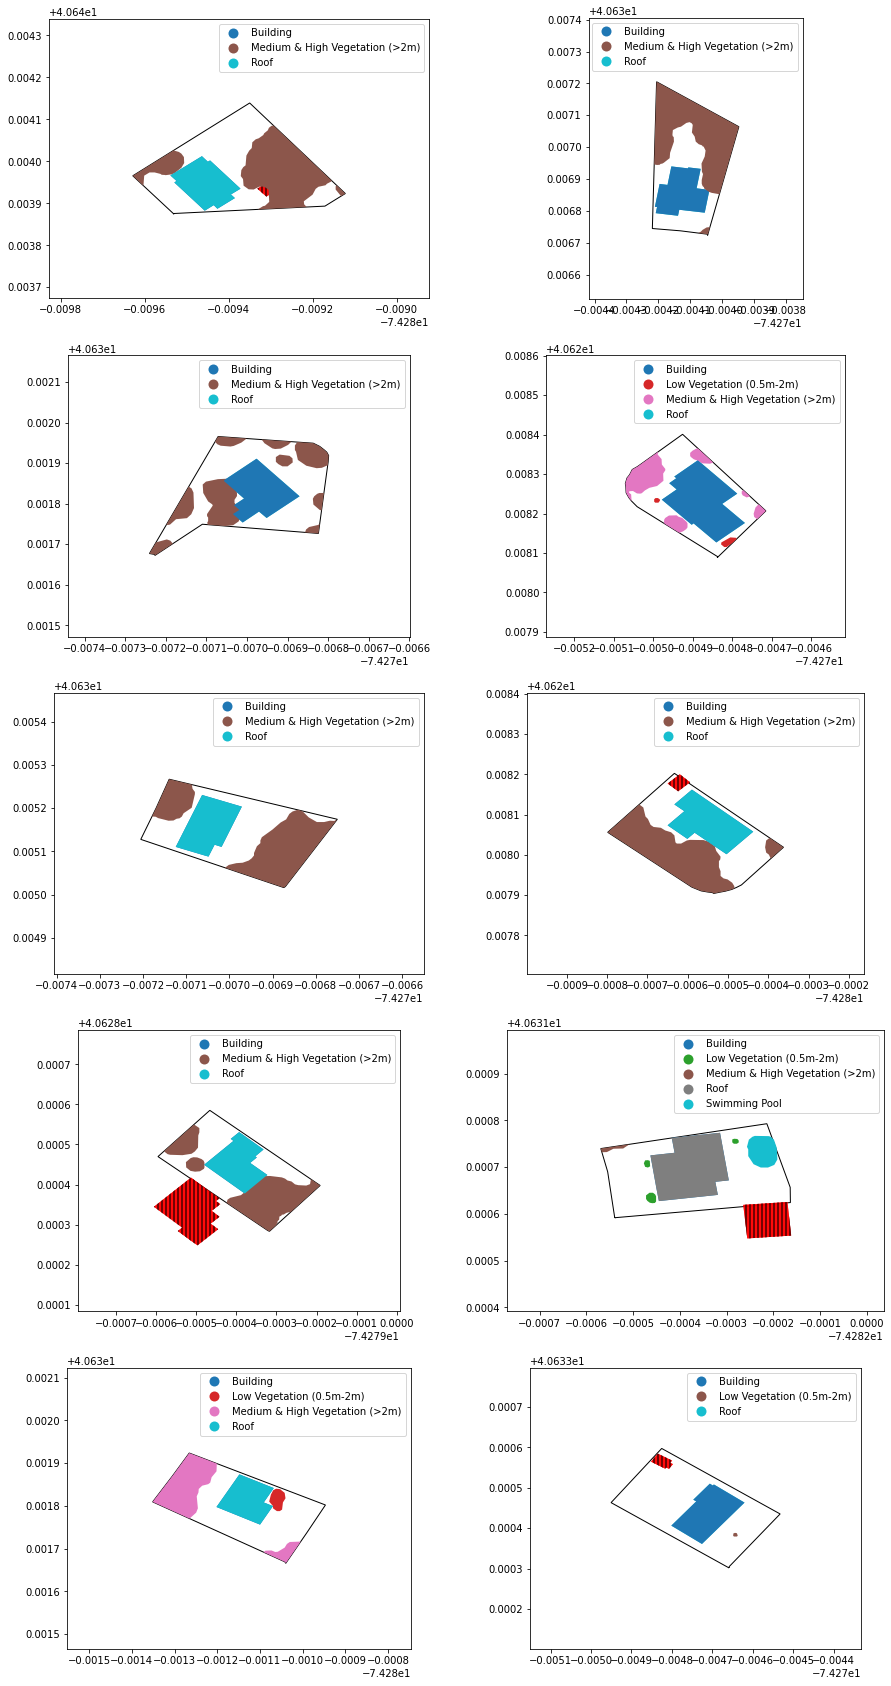

In [9]:
filtered_features_gdf = parcels.filter_features_in_parcels(
    parcels_gdf, features_gdf, country=country
)

# Plot sample
fig, axes = plt.subplots(N_EXAMPLES // 2, 2, figsize=(15, 3 * N_EXAMPLES))
axes = [ax for row in axes for ax in row]
for i, index in tqdm(enumerate(sample_indices)):
    row = parcels_gdf.loc[index]
    
    parcel_features_gdf = features_gdf[features_gdf.aoi_id == row.aoi_id]
    parcel_filtered_features_gdf = filtered_features_gdf[filtered_features_gdf.aoi_id == row.aoi_id]
    
    # Find discared features
    features_gdf_discard = parcel_features_gdf[
        ~parcel_features_gdf.feature_id.isin(parcel_filtered_features_gdf.feature_id)
    ]
    # Plot all features to discard
    features_to_show = features_gdf_discard.query("class_id in @VISUALISATION_IDS")
    if len(features_to_show) > 0:
        features_to_show.plot(
            ax=axes[i], fc="red", alpha=0.8, hatch="|||"
        )
    # Plot remaining features to keep
    features_to_show = parcel_filtered_features_gdf.query("class_id in @VISUALISATION_IDS")
    if len(features_to_show) > 0:
        features_to_show.plot(
            ax=axes[i], column="description", legend=True
        )
    # Plot parcel boundary
    axes[i].add_patch(
        PolygonPatch(row.geometry, fc="none", ec="k", alpha=1, zorder=0, lw=1)
    )
    axes[i].set_xlim(row.geometry.bounds[0] - plot_buffer, row.geometry.bounds[2] + plot_buffer)
    axes[i].set_ylim(row.geometry.bounds[1] - plot_buffer, row.geometry.bounds[3] + plot_buffer)
    axes[i].set_aspect("equal", "box")

# Create parcel rollup

Once we have the features in a parcel, all that remains is to flatten the features and attributes to tabular format. Note that roof and building values relate to the primary building and roof within a parcel. The primary building is defined as the building with the largest area within the parcel.

In [10]:
rollup_df = parcels.parcel_rollup(parcels_gdf, filtered_features_gdf, df_classes, "us", "largest_intersection")
# Merge parcel and metadata in
final_df = metadata_df.merge(rollup_df, on="aoi_id").merge(parcels_gdf, on="aoi_id")
# Show a few rows
final_df.head().T

,0,1,2,3,4
system_version,gen4-building_storm-1.0,gen4-building_storm-1.0,gen4-building_storm-1.0,gen4-building_storm-1.0,gen4-building_storm-1.0
link,"https://apps.nearmap.com/maps/#/@40.6423473,-7...","https://apps.nearmap.com/maps/#/@40.6351456,-7...","https://apps.nearmap.com/maps/#/@40.6345281,-7...","https://apps.nearmap.com/maps/#/@40.6309526,-7...","https://apps.nearmap.com/maps/#/@40.6369519,-7..."
date,2020-09-21,2020-09-21,2020-09-21,2020-09-21,2020-09-21
aoi_id,370dcd28-692a-52cd-b44e-3a88cb2605a8,92aa29b8-1105-57d3-9638-b9ab151778a9,656263e0-2cfb-5184-9fb3-f4f7eadc6c3b,1f5ea3af-ac86-5b9e-b206-94ac79683840,a4054bde-22d2-5acd-995e-b403282d5505
building_present,Y,Y,Y,Y,Y
building_count,1,1,1,1,1
building_total_area_sqft,1250,1234,1598,1784,1857
building_total_clipped_area_sqft,1249.8,1234.3,1598.2,1784.3,1857.3
building_confidence,0.994141,0.994141,0.998047,0.990234,0.994141
primary_building_area_sqft,1250.0,1234.0,1598.0,1784.0,1857.0


In [11]:
final_df.to_csv("AI_Offline_Parcel_example.csv", index=False)